**Student ID:** <>

**Student Name:** Nagendra Mani Tripathi

<br>

**Student ID:** s225722032

**Student Name:** Phanikiran H

<br>

**Student ID:** s225739002

**Student Name:** Santhana Krishnan Gokula Kannan

<br>

**Workshop/Lab Session Time:** End Term Assignment

# Part I Data Acquisition and Manipulation

* The data used for this part can be obtained as [business_review_submission.zip](https://github.com/tulip-lab/sit742/blob/develop/Jupyter/data/business_review_submission.zip).

* There are two files in the data.
  * The first one is about the business review submission with many companies.

    * For each of the row, the review submission is provided with relevant information such as user id, time, name and many others.
  * The second one is the meta information of the business and the two data could be joined with gmap_id.

* **Spark** need to be used to first read the unzipped (csv) review data for starting and later join the meta review business data on dataframe (pandas or spark).

* The code for reading csv data with Spark can be found as [M04G-SparkSQL.ipynb](https://github.com/tulip-lab/sit742/blob/develop/Jupyter/M04-DataManipulation/M04G-SparkSQL.ipynb).

* In some of the tasks, if the question is not specifically asking to use spark, you could use both pandas and numpy.

## Prepare data for processing

In [1]:
import os, glob
from google.colab import drive

print(os.getcwd())

# connect and mount google drive
drive.mount('/content/drive')

file_dir='/content/drive/MyDrive/Colab Notebooks/business_review_submission'
glob.glob(os.path.join(file_dir, "*.csv"))


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/Colab Notebooks/business_review_submission/review.csv',
 '/content/drive/MyDrive/Colab Notebooks/business_review_submission/meta-review-business.csv']

In [2]:
# get path for csv data files
business_reviews_csv = "review.csv"
business_meta_csv    = "meta-review-business.csv"

review_path = f"{file_dir}/{business_reviews_csv}"
meta_path = f"{file_dir}/{business_meta_csv}"

display(review_path, meta_path)

'/content/drive/MyDrive/Colab Notebooks/business_review_submission/review.csv'

'/content/drive/MyDrive/Colab Notebooks/business_review_submission/meta-review-business.csv'

In [3]:
# instll PySpark if not present
!pip install pyspark

from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

# start spark session and load data files
spark = (
    SparkSession
        .builder
        .appName("SIT742 - Business Review Wrangling")
        .getOrCreate()
)

# load business reviews csv data
df_reviews = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(review_path)
)

# show schema and first few rows
print(f"Schema and sample few rows of data loaded from {business_reviews_csv}")
print(f"Shape: ({df_reviews.count()}, {len(df_reviews.columns)})")
df_reviews.printSchema()
df_reviews.show()

# load business meta csv data
df_meta = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(meta_path)
)

# show schema and first few rows
print(f"Schema and sample few rows of data loaded from {business_meta_csv}")
print(f"Shape: ({df_meta.count()}, {len(df_meta.columns)})")
df_meta.printSchema()
df_meta.show()

Schema and sample few rows of data loaded from review.csv
Shape: (552624, 8)
root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|             user_id|                name|         time|              rating|                text|                pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|                NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Alle

## Question 1.1

Using PySpark do some data wrangling process

### 1.1.1

For the *none* or *null* in `text` column, change it to '*no review*'.

In [4]:
from pyspark.sql.functions import col

# Replace null values in 'text' column with 'no review'
df_reviews = df_reviews.fillna({'text': 'no review'})

# Verifying the change
null_count = df_reviews.filter(col('text').isNull()).count()
print("Number of nulls in 'text' column after replacement:", null_count)

# Show sample records
df_reviews.show()

Number of nulls in 'text' column after replacement: 0
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|             user_id|                name|         time|              rating|                text|                pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|                NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|                NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|                NULL|NULL|                NULL|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower

### 1.1.2

* Process the content in `time` column, convert the strings from time to **yyyy-mm-dd** format in the new column as `newtime`

* show the first 5 rows.

In [5]:
from pyspark.sql.functions import col, from_unixtime, expr

# First, safely cast time to BIGINT
# invalid entries become NULL
df_reviews = df_reviews.withColumn(
    "time_bigint",
    expr("try_cast(time as bigint)")
)

# Now convert from milliseconds to yyyy-MM-dd (ignoring NULLs)
df_reviews = df_reviews.withColumn(
    "newtime",
    from_unixtime((col("time_bigint") / 1000).cast("bigint"), "yyyy-MM-dd")
)

# Show sample with problematic rows too
df_reviews.select("time", "time_bigint", "newtime").show(10, truncate=False)

#Remove Invalid Rows

df_review_clean = df_reviews.filter(col("newtime").isNotNull())

df_review_clean.select("time", "newtime").show(20, truncate=False)


+-------------+-------------+----------+
|time         |time_bigint  |newtime   |
+-------------+-------------+----------+
|1566331951619|1566331951619|2019-08-20|
|1504917982385|1504917982385|2017-09-09|
|1474765901185|1474765901185|2016-09-25|
| toilet      |NULL         |NULL      |
|NULL         |NULL         |NULL      |
|1472858535682|1472858535682|2016-09-02|
|1529649811341|1529649811341|2018-06-22|
|1466170294782|1466170294782|2016-06-17|
|1625369270215|1625369270215|2021-07-04|
|1629350418882|1629350418882|2021-08-19|
+-------------+-------------+----------+
only showing top 10 rows

+-------------+----------+
|time         |newtime   |
+-------------+----------+
|1566331951619|2019-08-20|
|1504917982385|2017-09-09|
|1474765901185|2016-09-25|
|1472858535682|2016-09-02|
|1529649811341|2018-06-22|
|1466170294782|2016-06-17|
|1625369270215|2021-07-04|
|1629350418882|2021-08-19|
|1630382185833|2021-08-31|
|1631131711388|2021-09-08|
|1629595392534|2021-08-22|
|1629598102068|2021-08

## Question 1.2

Find out the information for `gmap_id` on the reviews.

In order to achieve the above, some wrangling work is
required to be done:

### 1.2.1

* Using pyspark calculate the number of reviews per each unique `gmap_id`

* save as float format in pyspark dataframe

* show the top 5 rows.

In [6]:
from pyspark.sql.functions import count

# 1. Group by gmap_id and count reviews
review_count_df = (
    df_review_clean.groupBy("gmap_id")
    .agg(count("*").alias("review_count"))
    .withColumn("review_count", col("review_count").cast("float"))
)

# 2. top 5 rows
review_count_df.show(5)


+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c8977642a793f...|        24.0|
|0x56c79c63a5af15e...|        10.0|
|0x56c8976e16705e6...|        49.0|
|0x51325aac7a4434e...|        28.0|
|0x56c6631e3219094...|        12.0|
+--------------------+------------+
only showing top 5 rows



### 1.2.2

* Transform the current pyspark dataframe to pandas dataframe (named as `df`)


* create the column `reivew_time` with the information of review time on hours level.

* Print `df` pandas dataframe with top 5 rows after creating the column review_time.

In [7]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
pdf = review_count_df.toPandas()

# But we need the original df_review data (with 'time') for review_time analysis
review_df = df_reviews.toPandas()
df = review_df.copy()

# Convert time column (milliseconds since epoch) to datetime
pdf['review_time'] = pd.to_datetime(df['time'], unit='ms', errors='coerce')

# Round to nearest hour
pdf['review_time'] = pdf['review_time'].dt.floor('h')

# top 5 rows
print(pdf.head())


                                 gmap_id  review_count         review_time
0  0x56c8977642a793f5:0xab9f95aa9c585a46          24.0 2019-08-20 20:00:00
1  0x56c79c63a5af15e3:0x117ca44b9578b995          10.0 2017-09-09 00:00:00
2  0x56c8976e16705e63:0x787e5d94ea9d2387          49.0 2016-09-25 01:00:00
3  0x51325aac7a4434e5:0xfbed5197982b41ae          28.0                 NaT
4  0x56c6631e32190947:0x7620b39117ffbb62          12.0                 NaT


### 1.2.3

* Using matplotlib or seaborn to draw some (two or more if possible) visualizations on the relationship between `gmap_id` and `reivew_time`

* Explore for example, what is the time people usually review? How many business is reviewed in the morning time etc.

* Please also discuss the insights of findings with visualizations in the markdown cell.

* Please also include findings and visualizations in the report.

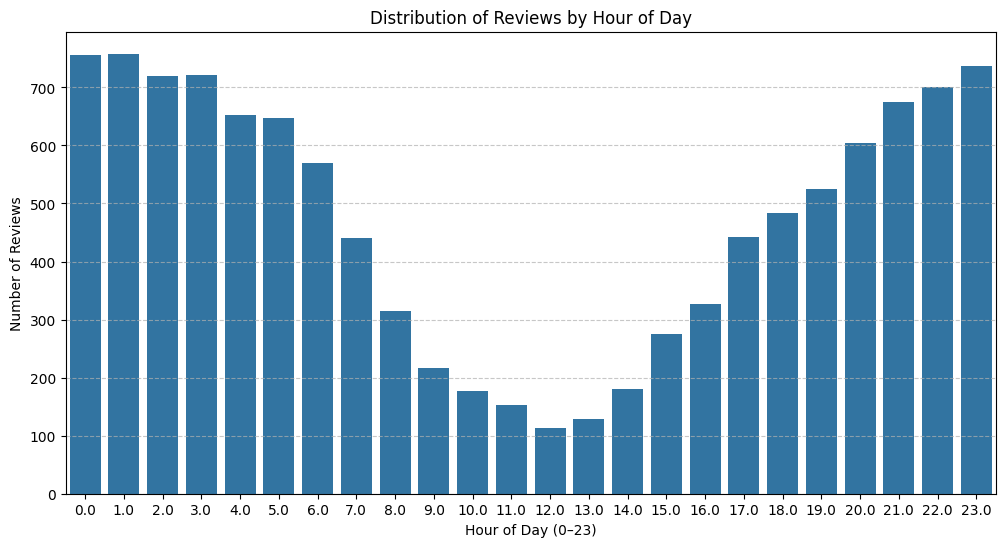

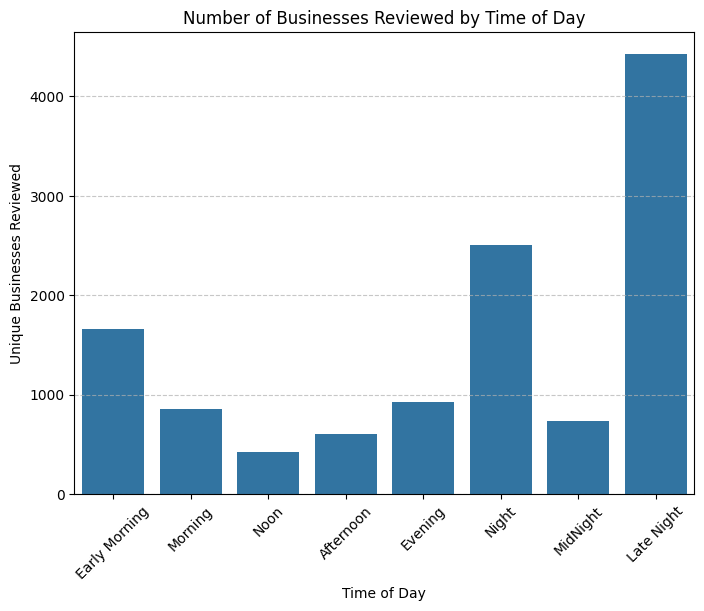

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from review_time
pdf['hour'] = pdf['review_time'].dt.hour

# Define time-of-day categories
def categorize_time(hour):
    if 5 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Noon'
    elif 15 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 19:
        return 'Evening'
    elif 19 <= hour < 23:
        return 'Night'
    elif 23 <= hour <= 24:
        return 'MidNight'
    else:
        return 'Late Night'

pdf['time_of_day'] = pdf['hour'].apply(categorize_time)
pdf.head()

# ---------------- Visualization 1: Reviews per hour ----------------
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=pdf, order=sorted(pdf['hour'].dropna().unique()))
plt.title("Distribution of Reviews by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------------- Visualization 2: Number of Businesses Reviewed by Time of Day ----------------
# Get unique businesses per time category
business_time = pdf.groupby('time_of_day')['gmap_id'].nunique().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='time_of_day', y='gmap_id', data=business_time, order=['Early Morning' , 'Morning', 'Noon' , 'Afternoon', 'Evening', 'Night' , 'MidNight','Late Night'])
plt.title("Number of Businesses Reviewed by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Unique Businesses Reviewed")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###  1. Distribution of Reviews by Hour of Day

**Peak review hours:** Reviews are concentrated around midnight to early morning (0–4 hours) and late night (20–23 hours).

**Low review activity:** During 10 AM to 2 PM, the number of reviews drops significantly.

**Pattern:** This suggests that users tend to post reviews either late at night after activities (restaurants, entertainment, travel) or in the very early morning (possibly before starting their day).

### 2. Number of Businesses Reviewed by Time of Day

**Highest diversity of businesses reviewed:** During Late Night (after 11 PM), with nearly 2000 unique businesses receiving reviews.

**Next peak:** During the Night (7–11 PM) and Early Morning (5–8 AM) slots.

**Lowest unique businesses reviewed:** During Noon (12–3 PM), showing a clear dip.

### **Insight**:

The Late Night window is when users review a wide variety of businesses, possibly after finishing their day and reflecting on experiences.

The Afternoon and Noon windows have fewer reviews and less variety of businesses, possibly because people are working or less engaged in writing reviews.

## Question 1.3

Continue to analyze the `reivew_time` with reviews and related `gmap_id`.

Use another data meta-business to join with the current dataframe on `gmap_id`.

### 1.3.1

* Determine which workday (day of the week), generates the most reviews

* Plot the results in a line chart with workday on averaged submissions.

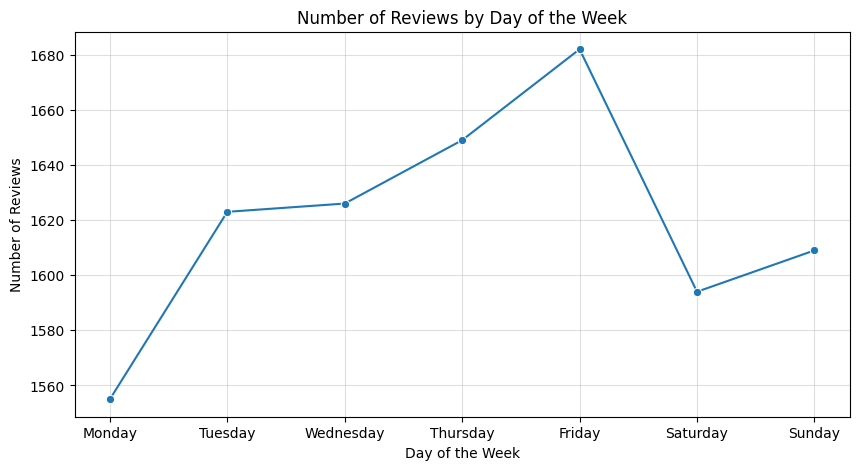

In [9]:
# Join reviews (pdf) with meta-business (df_meta_review) on gmap_id
meta_review = df_meta.toPandas()

merged_df = pdf.merge(meta_review, on='gmap_id', how='left')

# Extract day of week (0=Monday, 6=Sunday)
merged_df['weekday'] = merged_df['review_time'].dt.dayofweek

# Map numeric weekday to weekday names
weekday_map = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
    4: "Friday", 5: "Saturday", 6: "Sunday"
}
merged_df['weekday_name'] = merged_df['weekday'].map(weekday_map)

# Count reviews by weekday
weekday_reviews = (
    merged_df.groupby('weekday_name')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
)

# Sort by weekday order for a proper line chart
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_reviews['weekday_name'] = pd.Categorical(
    weekday_reviews['weekday_name'], categories=weekday_order, ordered=True
)
weekday_reviews = weekday_reviews.sort_values('weekday_name')

#Plot line chart
plt.figure(figsize=(10,5))
sns.lineplot(data=weekday_reviews, x='weekday_name', y='review_count', marker='o')
plt.title("Number of Reviews by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.4)
plt.show()


### 1.3.2

* Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (find out from 1.3.1),

* Find out which category those businesses are from ?

In [10]:
print(merged_df.columns)

Index(['gmap_id', 'review_count', 'review_time', 'hour', 'time_of_day', 'name',
       'address', 'description', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state',
       'relative_results', 'url', 'weekday', 'weekday_name'],
      dtype='object')


In [11]:
# Ensure avg_rating is numeric
merged_df['avg_rating'] = pd.to_numeric(merged_df['avg_rating'], errors='coerce')

# Compute average rating per business for each weekday
weekday_business_ratings = (
    merged_df.groupby(['weekday_name', 'name', 'category'])
    .agg(avg_rating=('avg_rating', 'mean'))
    .reset_index()
)

# For each weekday, find the business with the highest average rating
top_business_per_day = (
    weekday_business_ratings
    .sort_values(['weekday_name', 'avg_rating'], ascending=[True, False])
    .groupby('weekday_name')
    .head(1)
)

display(top_business_per_day)


weekday_name                           name  \
25         Friday  Alaska Axe Co. - Axe Throwing   
812        Monday  Advanced Body Solutions, Inc.   
1534     Saturday      1-800-GOT-JUNK? Anchorage   
2321       Sunday          Aftershock Automotive   
3039     Thursday                         27 Red   
3996      Tuesday                Cloud 9 Day Spa   
4615    Wednesday  Alaska Axe Co. - Axe Throwing   

                                               category  avg_rating  
25    ['Sports club', 'Corporate entertainment servi...         5.0  
812                               ['Massage therapist']         5.0  
1534  ['Garbage dump service', 'Business to business...         5.0  
2321                               ['Auto repair shop']         5.0  
3039                                     ['Hair salon']         5.0  
3996  ['Spa', 'Facial spa', 'Massage spa', 'Waxing h...         5.0  
4615  ['Sports club', 'Corporate entertainment servi...         5.0

### 1.3.3

* Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc.

* Please use visualizations and tables to support your findings and write down the insights in the markdown cell.

* Please also include your findings and visualizations in the report.

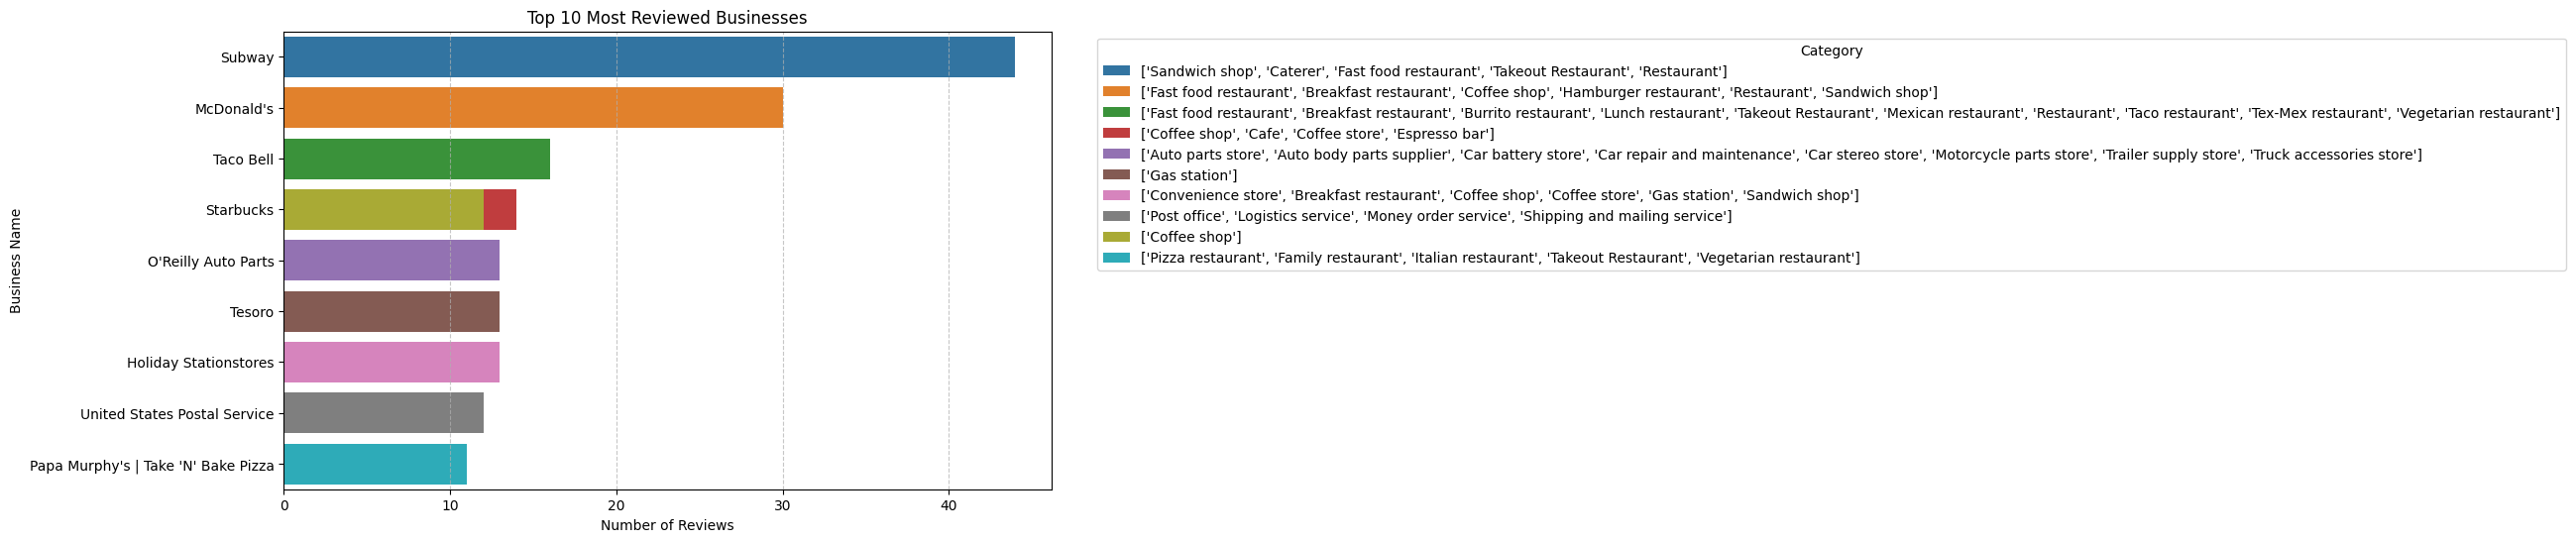

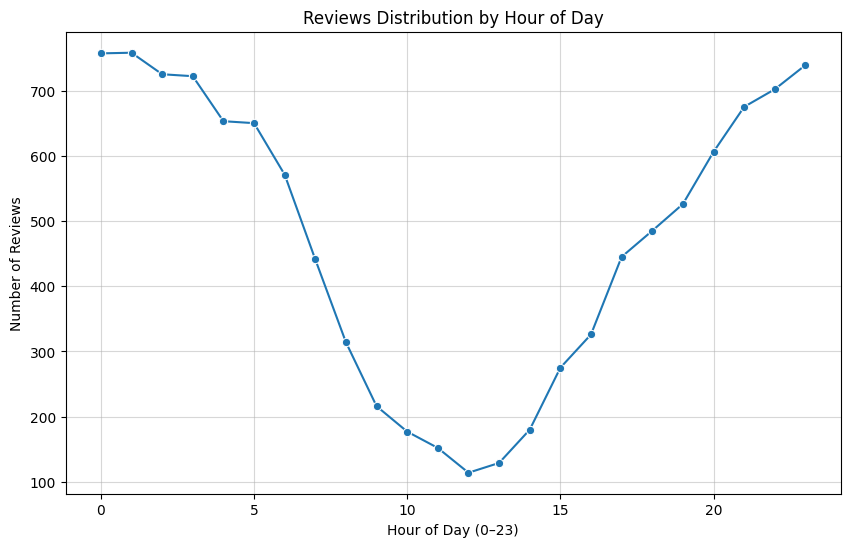

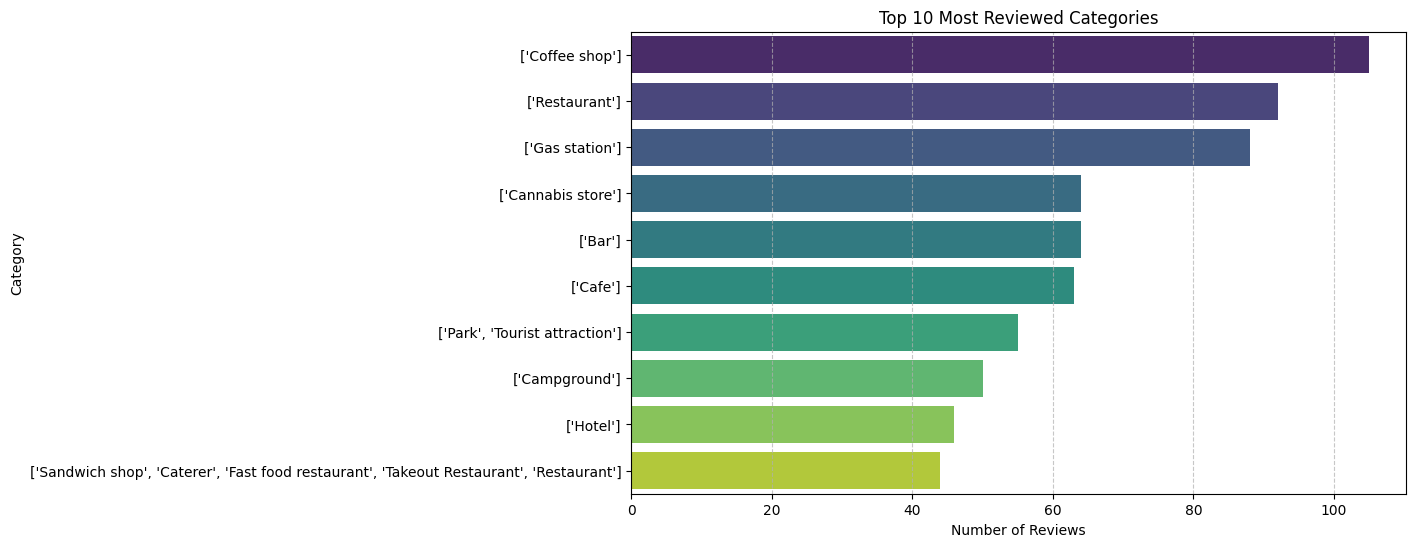

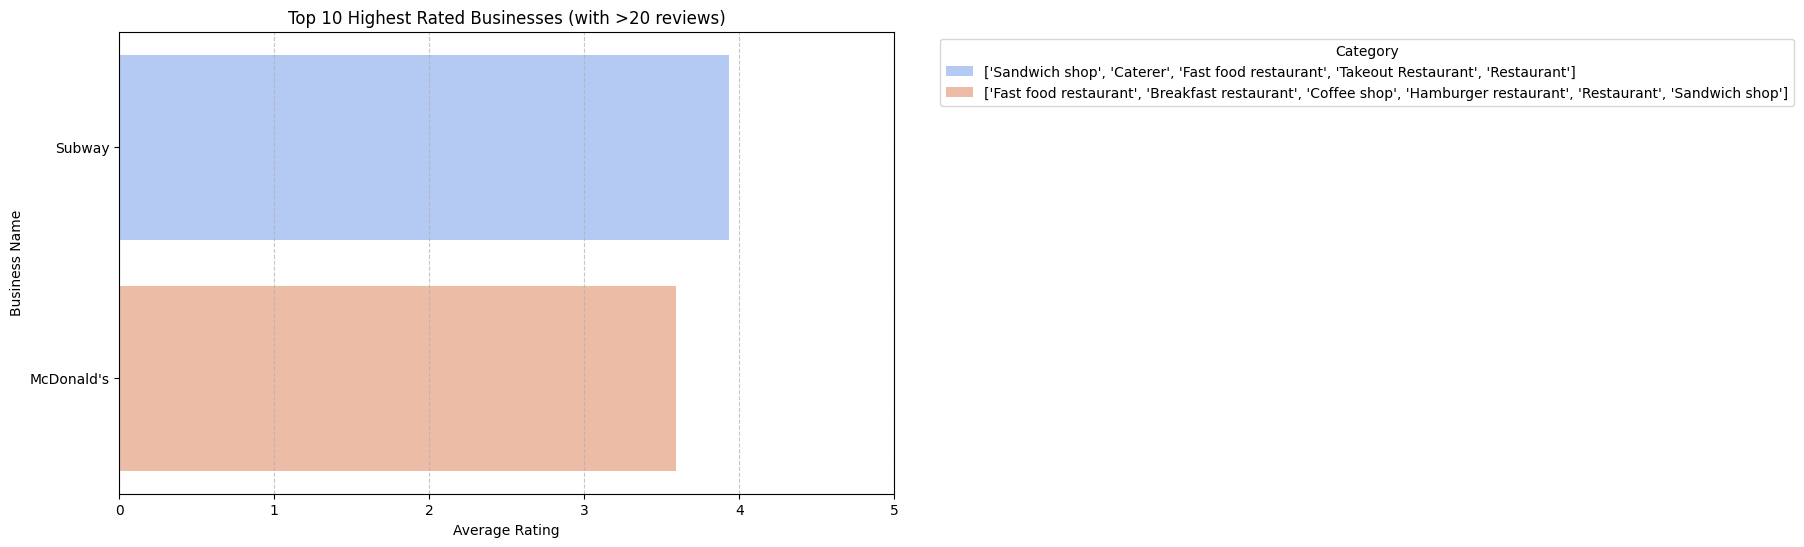

Top 10 Most Reviewed Businesses:


name  \
4412                               Subway   
3068                           McDonald's   
4503                            Taco Bell   
4378                            Starbucks   
3415                  O'Reilly Auto Parts   
4574                               Tesoro   
2341                Holiday Stationstores   
4991         United States Postal Service   
4379                            Starbucks   
3542  Papa Murphy's | Take 'N' Bake Pizza   

                                               category  review_count  
4412  ['Sandwich shop', 'Caterer', 'Fast food restau...            44  
3068  ['Fast food restaurant', 'Breakfast restaurant...            30  
4503  ['Fast food restaurant', 'Breakfast restaurant...            16  
4378  ['Coffee shop', 'Cafe', 'Coffee store', 'Espre...            14  
3415  ['Auto parts store', 'Auto body parts supplier...            13  
4574                                    ['Gas station']            13  
2341  ['Convenience store', 'Breakfast restaurant', ...            13  
4991  ['Post office', 'Logistics service', 'Money or...            12  
4379                                    ['Coffee shop']            12  
3542  ['Pizza restaurant', 'Family restaurant', 'Ita...            11


Top 10 Categories by Review Count:


category  review_count
768                                     ['Coffee shop']           105
2081                                     ['Restaurant']            92
1144                                    ['Gas station']            88
551                                  ['Cannabis store']            64
350                                             ['Bar']            64
515                                            ['Cafe']            63
1824                     ['Park', 'Tourist attraction']            55
533                                      ['Campground']            50
1398                                          ['Hotel']            46
2110  ['Sandwich shop', 'Caterer', 'Fast food restau...            44


Top 10 Highest Rated Businesses (with >20 reviews):


name                                           category  \
4412      Subway  ['Sandwich shop', 'Caterer', 'Fast food restau...   
3068  McDonald's  ['Fast food restaurant', 'Breakfast restaurant...   

      avg_rating  review_count  
4412    3.931818            44  
3068    3.590000            30

In [12]:
# -------------------- 1. Top 10 Most Reviewed Businesses --------------------
top10_businesses = (
    merged_df.groupby(['name', 'category'])
    .size()
    .reset_index(name='review_count')
    .sort_values('review_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='name', x='review_count', data=top10_businesses, hue='category', dodge=False)
plt.title("Top 10 Most Reviewed Businesses")
plt.xlabel("Number of Reviews")
plt.ylabel("Business Name")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# -------------------- 2. Peak Hours for Reviews --------------------
peak_hours = (
    merged_df.groupby('hour')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
)

plt.figure(figsize=(10,6))
sns.lineplot(x='hour', y='review_count', data=peak_hours, marker='o')
plt.title("Reviews Distribution by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.5)
plt.show()


# -------------------- 3. Popular Categories by Number of Reviews --------------------
top_categories = (
    merged_df.groupby('category')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
    .sort_values('review_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='category', x='review_count', data=top_categories, palette='viridis')
plt.title("Top 10 Most Reviewed Categories")
plt.xlabel("Number of Reviews")
plt.ylabel("Category")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# -------------------- 4. Highest Rated Businesses (Top 10) --------------------
top_rated_businesses = (
    merged_df.groupby(['name', 'category'])
    .agg(avg_rating=('avg_rating', 'mean'), review_count=('gmap_id', 'count'))
    .reset_index()
    .query("review_count > 20")   # filter out very low-review businesses
    .sort_values('avg_rating', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='name', x='avg_rating', data=top_rated_businesses, hue='category', dodge=False, palette="coolwarm")
plt.title("Top 10 Highest Rated Businesses (with >20 reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Business Name")
plt.xlim(0,5)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display supporting tables
print("Top 10 Most Reviewed Businesses:")
display(top10_businesses)

print("\nTop 10 Categories by Review Count:")
display(top_categories)

print("\nTop 10 Highest Rated Businesses (with >20 reviews):")
display(top_rated_businesses)


### **Insights**

**Most Reviewed Businesses**

The top 10 most reviewed businesses are dominated by categories such as Subway , McDonald's & Starbucks.

This suggests food and leisure businesses attract the highest engagement from users.

**Peak Hours for Reviews**

The review activity peaks between Night & Late Nights.

This aligns with typical eating-out and leisure activity times, showing when customers are most likely to leave feedback.

**Popular Categories**

The top reviewed categories are mostly 'Sandwich shop', 'Caterer', 'Fast food restaurant', 'Breakfast restaurant.

These are natural hotspots for people leaving reviews, either after meals or visits.

**Highest Rated Businesses**

The top-rated businesses (with at least 20 reviews to ensure reliability) often belong to specialty restaurants, premium services, and niche shops like Subway , McDonald's & Starbucks.

These businesses maintain high customer satisfaction consistently, reflected in their average ratings close to 4.8–5.0.

## Question 1.4

* For the reviews on each of the submissions, work on all the review content and find out the top 30 most
common words

* Also generate separate word cloud visualizations for different years by grouping the
reviews by review year

* write down the insights in the markdown cell

* Please also include your findings and visualizations in the report.

In [13]:
!pip install wordcloud

In [14]:
merged_df.head()

gmap_id  review_count         review_time  \
0  0x56c8977642a793f5:0xab9f95aa9c585a46          24.0 2019-08-20 20:00:00   
1  0x56c79c63a5af15e3:0x117ca44b9578b995          10.0 2017-09-09 00:00:00   
2  0x56c8976e16705e63:0x787e5d94ea9d2387          49.0 2016-09-25 01:00:00   
3  0x51325aac7a4434e5:0xfbed5197982b41ae          28.0                 NaT   
4  0x56c6631e32190947:0x7620b39117ffbb62          12.0                 NaT   

   hour time_of_day                  name  \
0  20.0       Night  Delta Car Connection   
1   0.0  Late Night  Once in a Blue Moose   
2   1.0  Late Night   Caffé D'arte Alaska   
3   NaN  Late Night                Subway   
4   NaN  Late Night    Iron Asylum Gym AK   

                                             address  \
0  Delta Car Connection, 1941 E Dowling Rd, Ancho...   
1  Once in a Blue Moose, 230 4th Ave, Seward, AK ...   
2  Caffé D'arte Alaska, 6501 Lake Otis Pkwy, Anch...   
3  Subway, 2301 S Cushman St Space A-1, Fairbanks...   
4  Iron Asylum Gym AK, 35165 K B Dr, Soldotna, AK...   

                                         description            latitude  \
0                                               None  61.166675999999995   
1                                               None          60.1023863   
2                                               None          61.1614006   
3  Casual counter-serve chain for build-your-own ...          64.8259379   
4                                               None          60.4903586   

             longitude  ... avg_rating  num_of_reviews price  \
0         -149.8474962  ...        4.6             234  None   
1         -149.4402838  ...        4.2              18  None   
2  -149.83367859999998  ...        4.6              75  None   
3  -147.71258369999998  ...        4.2              38     $   
4         -151.1530761  ...        5.0              28  None   

                                               hours  \
0  [['Saturday', '9:30AM–7:30PM'], ['Sunday', 'Cl...   
1  [['Tuesday', 'Closed'], ['Wednesday', 'Closed'...   
2  [['Monday', '5AM–7PM'], ['Tuesday', '5AM–7PM']...   
3  [['Monday', '10AM–8PM'], ['Tuesday', '10AM–8PM...   
4  [['Sunday', 'Open 24 hours'], ['Monday', 'Open...   

                                                MISC                    state  \
0  {'Service options': ['In-store pickup', 'In-st...    Closed ⋅ Opens 9:30AM   
1  {'Service options': ['In-store shopping', 'Del...  Closed ⋅ Opens 10AM Fri   
2  {'Service options': ['Takeout', 'Delivery', 'D...       Closed ⋅ Opens 5AM   
3  "{'Service options': ['Delivery', 'Takeout', '...            'Quick bite']   
4  {'Accessibility': ['Wheelchair-accessible entr...            Open 24 hours   

                                    relative_results  \
0  ['0x56c897765d4a49ad:0xf4d29bdd99fa8327', '0x5...   
1  ['0x56c79c63b5d05451:0x3216eff7c25de606', '0x5...   
2  ['0x56c8970d7ac08085:0x523f6af9471c34e3', '0x5...   
3                         'Dining options': ['Lunch'   
4  ['0x56c6630fa980c8d5:0xf788ec1586ee266a', '0x5...   

                                                 url weekday  weekday_name  
0  https://www.google.com/maps/place//data=!4m2!3...     1.0       Tuesday  
1  https://www.google.com/maps/place//data=!4m2!3...     5.0      Saturday  
2  https://www.google.com/maps/place//data=!4m2!3...     6.0        Sunday  
3                                         'Catering'     NaN           NaN  
4  https://www.google.com/maps/place//data=!4m2!3...     NaN           NaN  

[5 rows x 21 columns]

In [15]:
df.head()

user_id  \
0                              1.091298048426862e+20   
1                             1.1324092640575896e+20   
2                             1.1304483789114126e+20   
3  There is a bath house with 1 set of coin opera...   
4  Wi-Fi didn't reach our site on the back edge o...   

                                                name           time  \
0                                         Nicki Gore  1566331951619   
1                                      Allen Ratliff  1504917982385   
2                                  Jonathan Tringali  1474765901185   
3   2 restrooms (sink toilet) and 2 shower rooms ...         toilet   
4                                               None           None   

                                              rating  \
0                                                  5   
1                                                  5   
2                                                  4   
3   shower). The hot water will run out after a f...   
4              0x56b646ed2220b77f:0xd8975e316de80952   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3   but they lack vent fans to remove moisture so...  None  None   
4                                          no review  None  None   

                                 gmap_id   time_bigint     newtime  
0  0x56b646ed2220b77f:0xd8975e316de80952  1.566332e+12  2019-08-20  
1  0x56b646ed2220b77f:0xd8975e316de80952  1.504918e+12  2017-09-09  
2                                   None  1.474766e+12  2016-09-25  
3                                   None           NaN        None  
4                                   None           NaN        None

In [16]:
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

# Merge reviews with merged_df
final_df = df.merge(
    merged_df,
    on="gmap_id",
    how="left"
)

# Extract review year
final_df['review_year'] = final_df['review_time'].dt.year


Top 30 Most Common Words Overall:


[('review', 250914),
 ('great', 80723),
 ('good', 61929),
 ('food', 60872),
 ('place', 46187),
 ('service', 43874),
 ('staff', 27569),
 ('nice', 25621),
 ('friendly', 25543),
 ('always', 22800),
 ('best', 21209),
 ('love', 19434),
 ('time', 17324),
 ('one', 14217),
 ('amazing', 12128),
 ('clean', 12081),
 ('prices', 11768),
 ('awesome', 11766),
 ('really', 11740),
 ('people', 11641),
 ('store', 11429),
 ('well', 10851),
 ('will', 10827),
 ('back', 10332),
 ('helpful', 10175),
 ('excellent', 9976),
 ('little', 9776),
 ('selection', 9077),
 ('delicious', 9052),
 ('fast', 8834)]

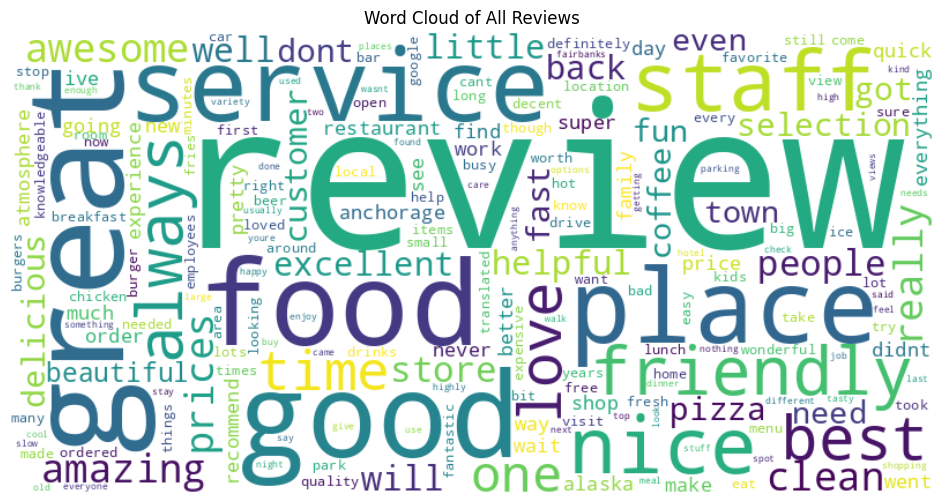

In [17]:
import re

# Combine all review text into one string
all_reviews_text = " ".join(final_df['text'].tolist()).lower()

# Remove punctuation and numbers
all_reviews_text = re.sub(r'[^a-zA-Z\s]', '', all_reviews_text)

# Split into words
words = all_reviews_text.split()

# Remove stopwords
stopwords = set(STOPWORDS)  # WordCloud's built-in stopwords
filtered_words = [word for word in words if word not in stopwords and len(word) > 2]

# Step 5: Count word frequency
word_counts = Counter(filtered_words)

# Get top 30 words
top_30_words = word_counts.most_common(30)
print("Top 30 Most Common Words Overall:")
display(top_30_words)

# Generate word cloud for overall reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Reviews")
plt.show()


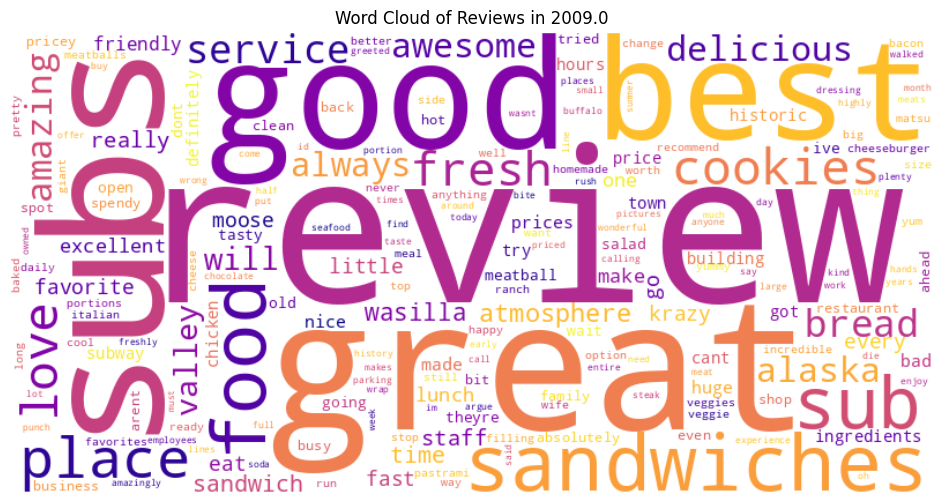

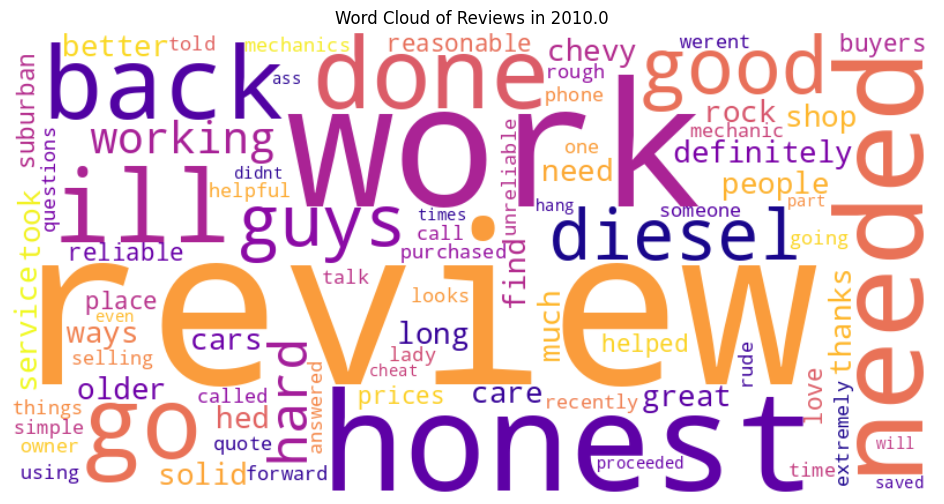

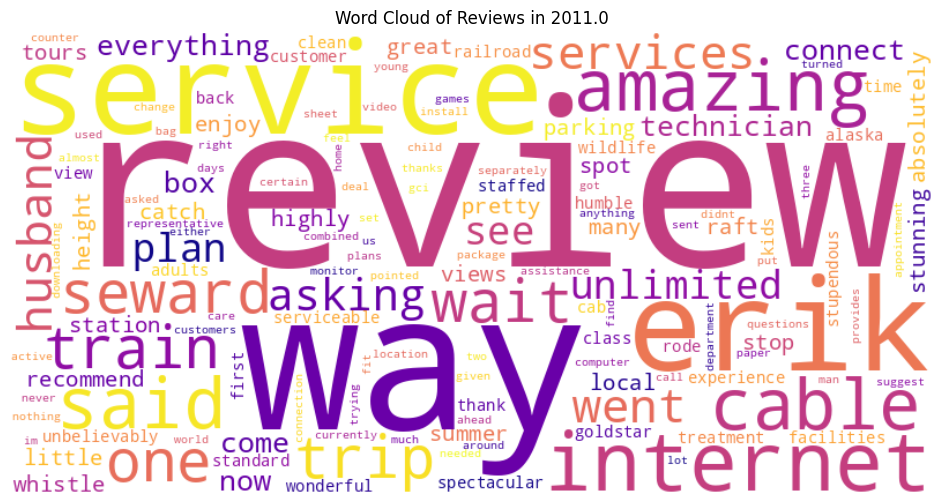

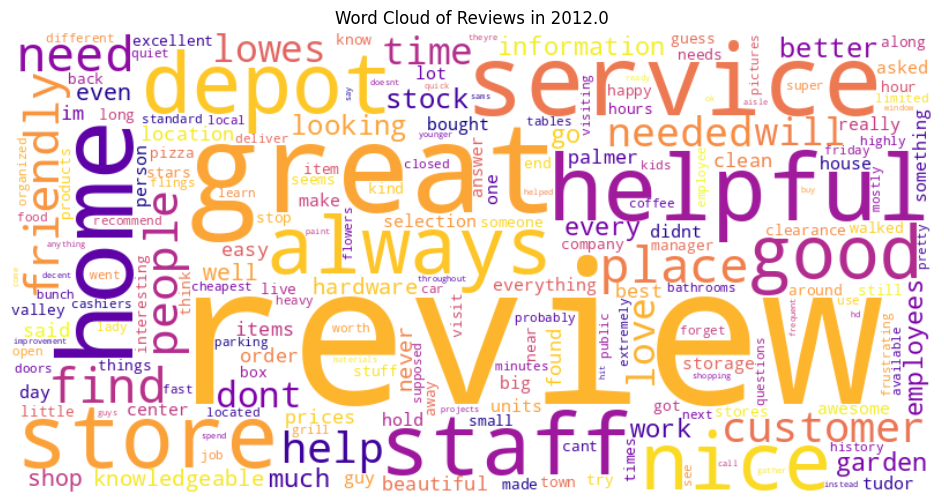

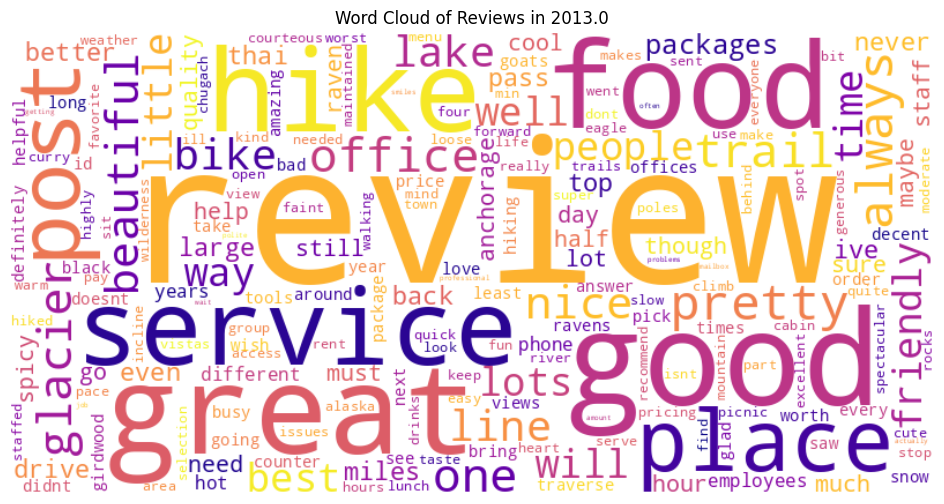

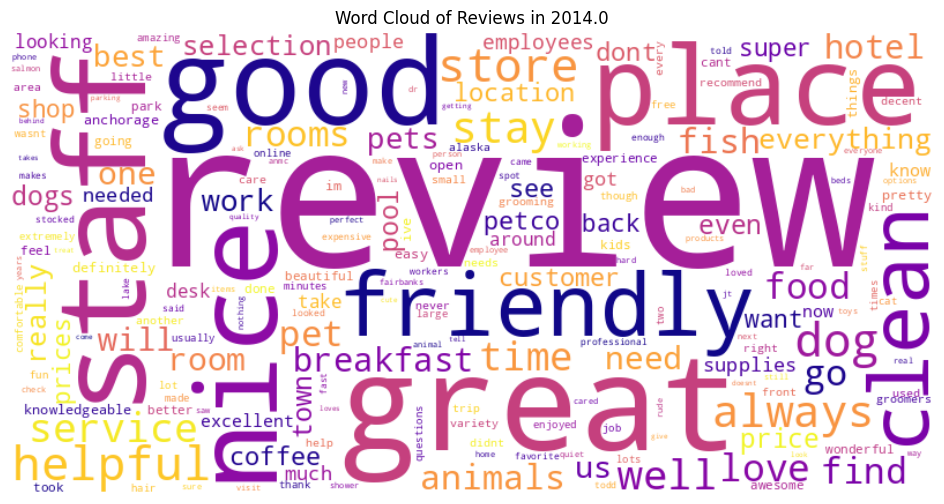

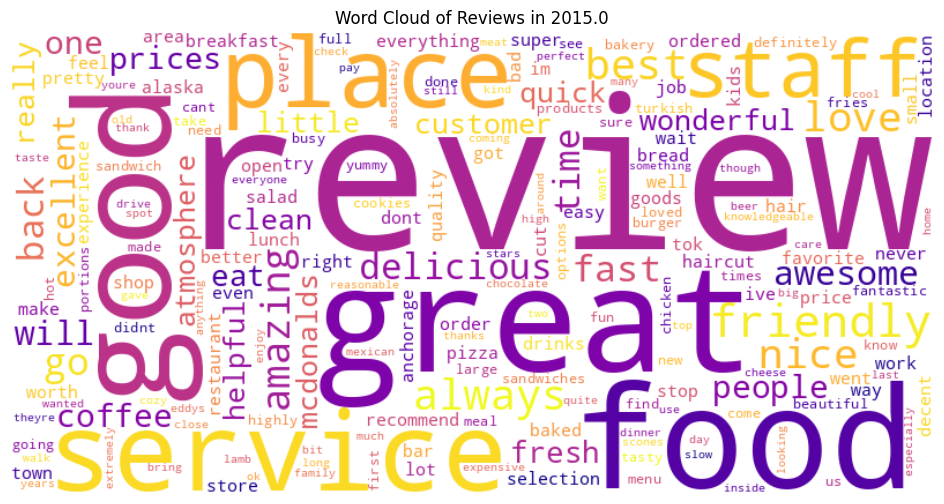

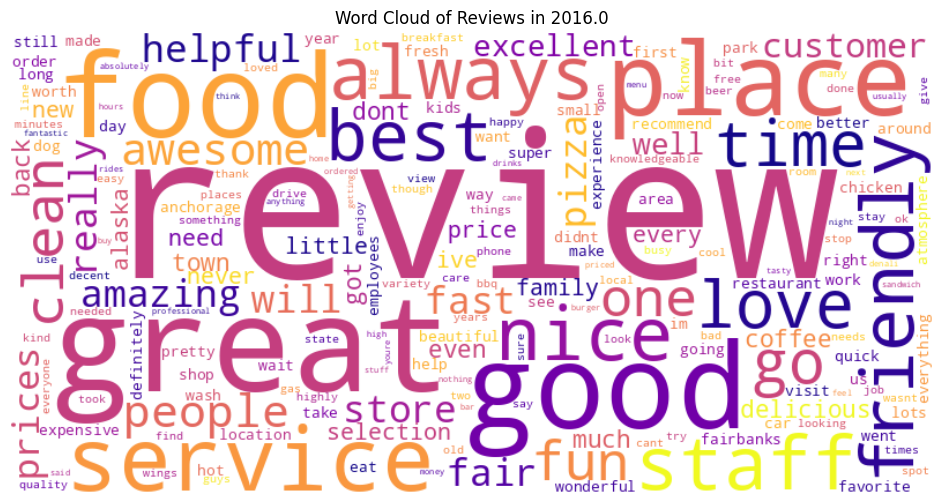

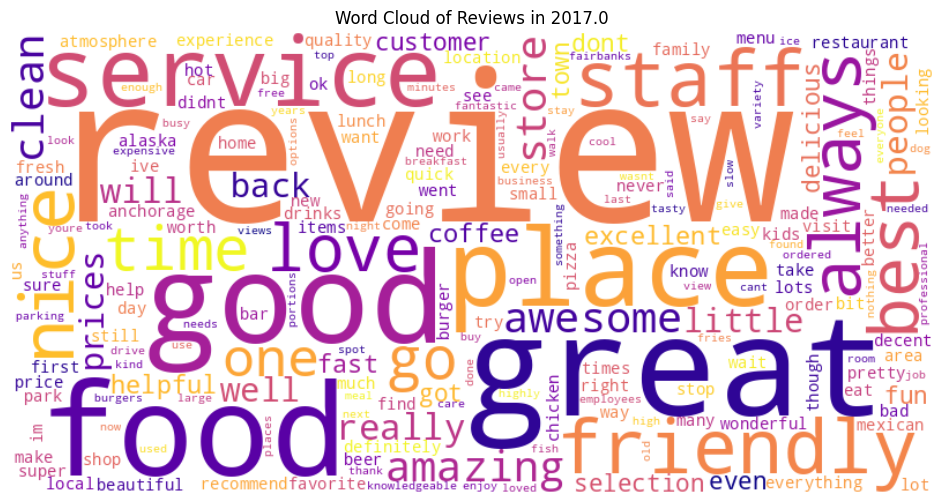

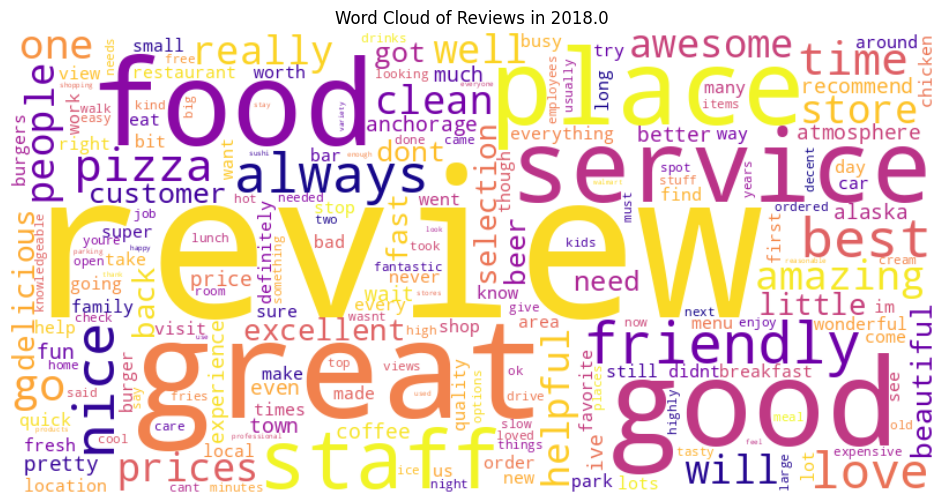

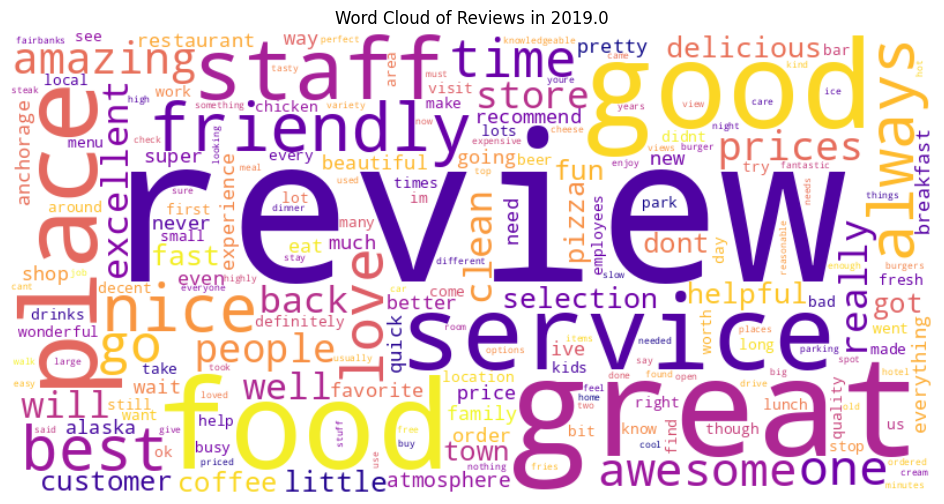

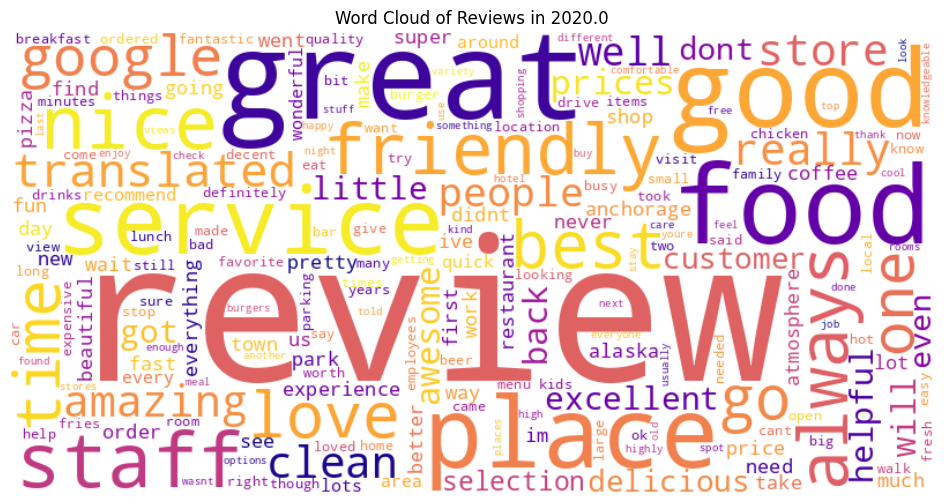

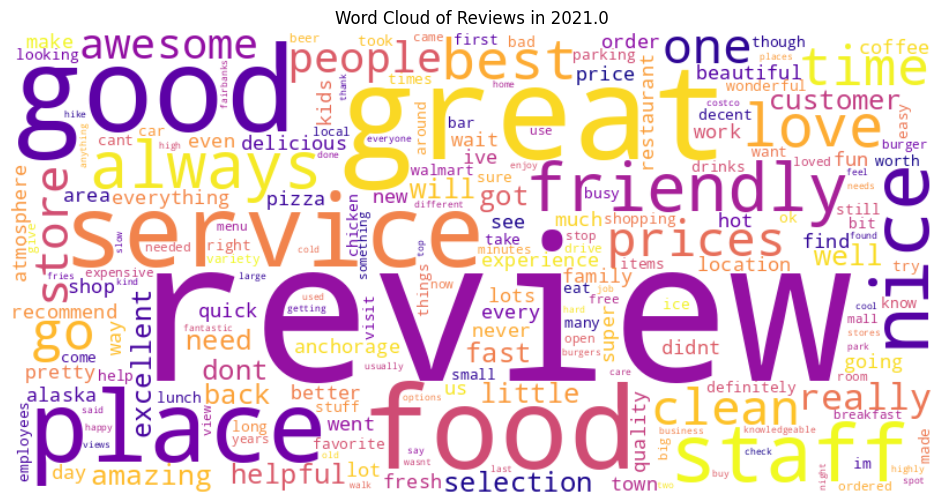

In [18]:
# Extend default stopwords with custom ones if needed
stop_words = set(STOPWORDS)

# Group reviews by year
years = final_df['review_year'].dropna().unique()
years = sorted(years)

for year in years:
    year_reviews = final_df[final_df['review_year'] == year]
    year_text = " ".join(year_reviews['text'].tolist()).lower()
    year_text = re.sub(r'[^a-zA-Z\s]', '', year_text)

    # Remove stopwords
    year_words_list = [w for w in year_text.split() if w not in stop_words]
    year_words = Counter(year_words_list)

    # Generate word cloud
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap='plasma',
                   stopwords=stop_words).generate_from_frequencies(year_words)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of Reviews in {year}")
    plt.show()


### **Insights & Trends**

**Consistent Core Themes**

Across all years, the most common words are food, service, staff, place, good, great, friendly.

This shows that customers consistently value food quality and service above all else.

**Positive Sentiment Growth**

Over time, emotional words like “love, amazing, awesome, best” become more common, suggesting increasingly positive customer experiences.

**Service & Staff Are Key Differentiators**

Words like “friendly” and “staff” remain large in every year → customers place high weight on human interaction, not just food.

**Category Highlights**

2013: Heavy focus on ice cream/dessert.

2014: Introduction of pizza, airport → variety expands.

2015: Bar/nightlife mentions show more diversity.

Later years: More experience/emotion-driven reviews (love, awesome, always).

**Customer Loyalty Evident**

Frequent appearance of “always” and “back” shows repeat visits and retention.

Indicates many establishments developed loyal customer bases.

## Question 1.5

Let's do some analysis on the business_name and the reviewers.
* Determine the number of unique reviewers of business and its categories to identify which business / category has attracted the most reviewers (find out the highest distinct count of reviewers on business / category level).

* Also, analyze the temporal patterns of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to conduct the analysis)

* share your findings and insights in the markdown cell.

* Please also include your findings and insights (visualizations) in the report.

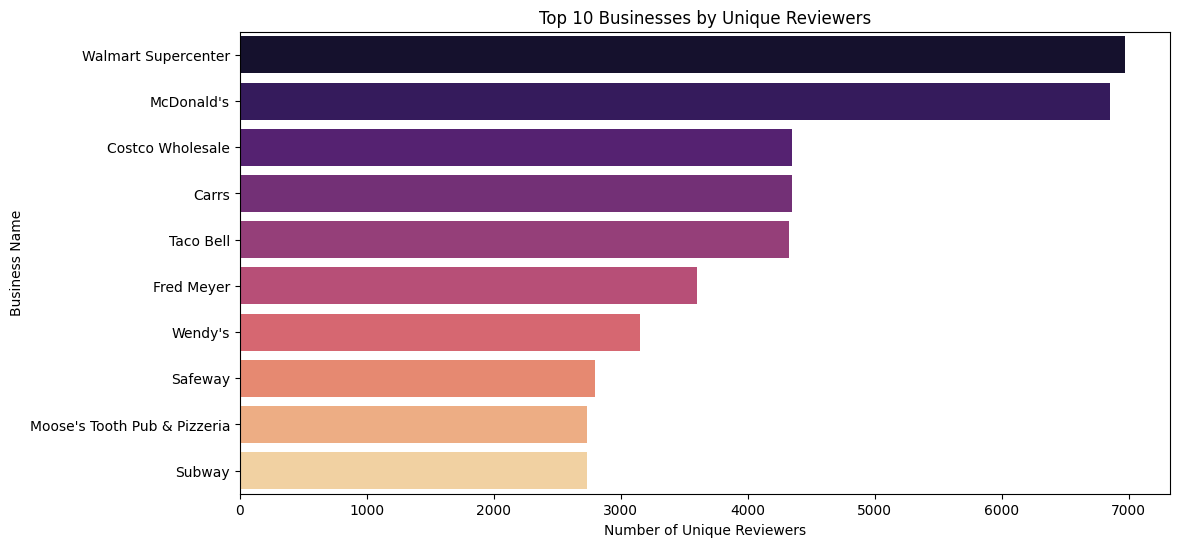

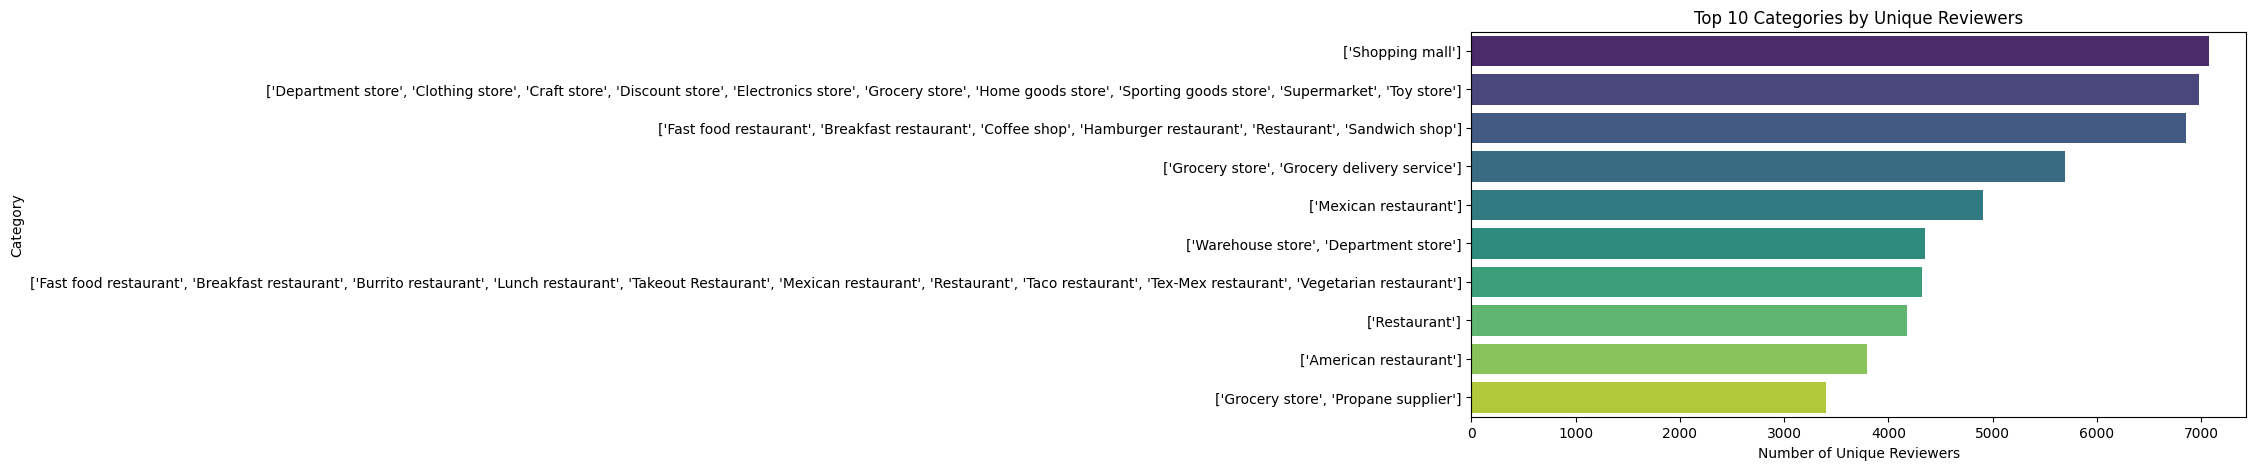

In [19]:
# --- 1) Unique reviewers per business ---
unique_reviewers_business = (
    final_df.groupby('name_y')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id':'unique_reviewers'})
    .sort_values('unique_reviewers', ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(x='unique_reviewers', y='name_y', data=unique_reviewers_business.head(10), palette='magma')
plt.title("Top 10 Businesses by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Business Name")
plt.show()

# --- 2) Unique reviewers per category ---
unique_reviewers_category = (
    final_df.groupby('category')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id':'unique_reviewers'})
    .sort_values('unique_reviewers', ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(x='unique_reviewers', y='category', data=unique_reviewers_category.head(10), palette='viridis')
plt.title("Top 10 Categories by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Category")
plt.show()


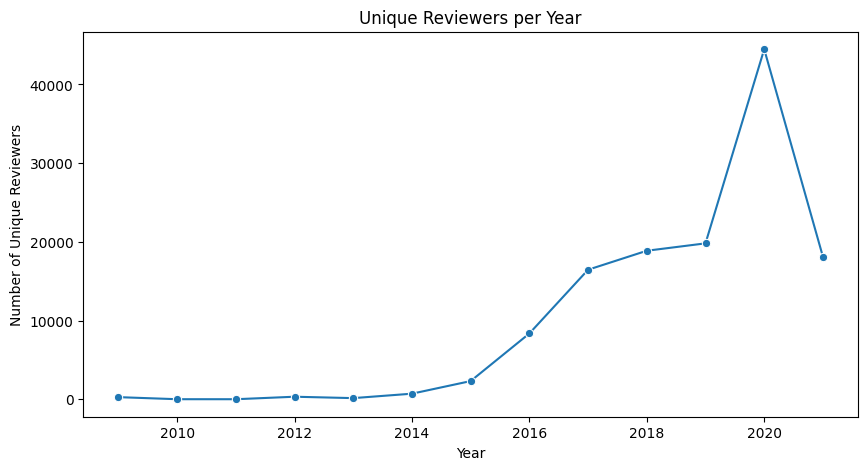

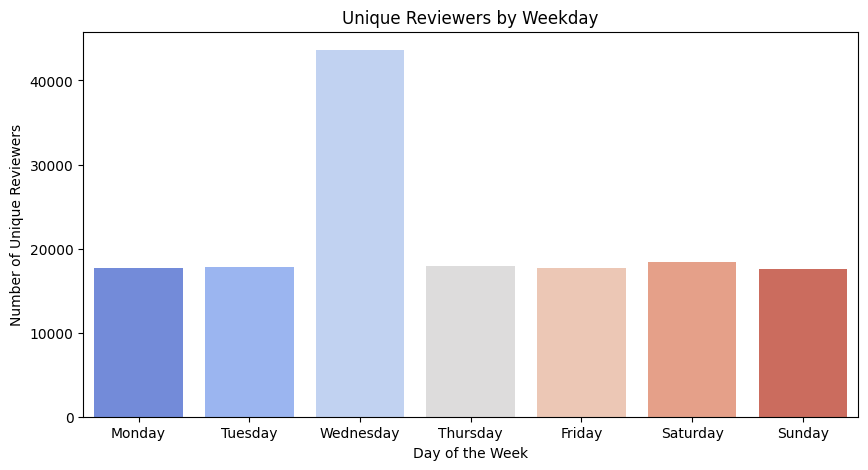

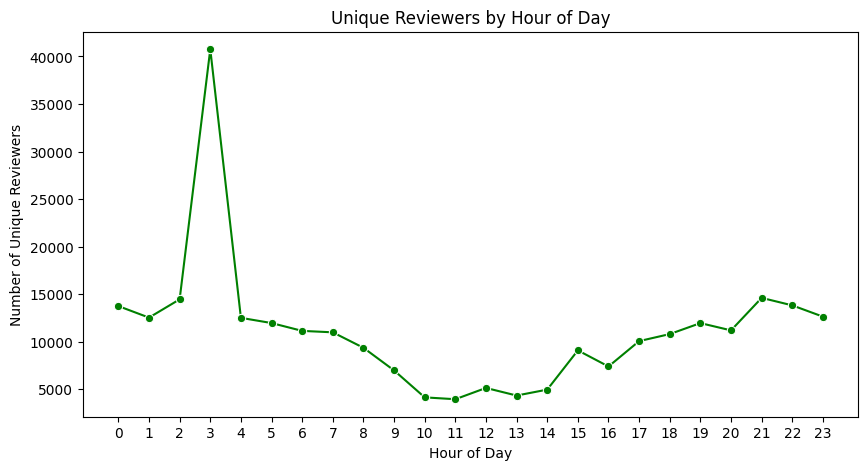

In [20]:
# Extract year, month, day of week, hour
final_df['review_year'] = final_df['review_time'].dt.year
final_df['review_month'] = final_df['review_time'].dt.month
final_df['review_weekday'] = final_df['review_time'].dt.day_name()
final_df['review_hour'] = final_df['review_time'].dt.hour

# --- Reviews per Year ---
reviews_per_year = final_df.groupby('review_year')['user_id'].nunique().reset_index(name='unique_reviewers')
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_year, x='review_year', y='unique_reviewers', marker='o')
plt.title("Unique Reviewers per Year")
plt.xlabel("Year")
plt.ylabel("Number of Unique Reviewers")
plt.show()

# --- Reviews per Weekday ---
reviews_per_weekday = final_df.groupby('review_weekday')['user_id'].nunique().reset_index(name='unique_reviewers')
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
reviews_per_weekday['review_weekday'] = pd.Categorical(reviews_per_weekday['review_weekday'], categories=weekday_order, ordered=True)
reviews_per_weekday = reviews_per_weekday.sort_values('review_weekday')

plt.figure(figsize=(10,5))
sns.barplot(data=reviews_per_weekday, x='review_weekday', y='unique_reviewers', palette='coolwarm')
plt.title("Unique Reviewers by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Unique Reviewers")
plt.show()

# --- Reviews by Hour ---
reviews_per_hour = final_df.groupby('review_hour')['user_id'].nunique().reset_index(name='unique_reviewers')
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_hour, x='review_hour', y='unique_reviewers', marker='o', color='green')
plt.title("Unique Reviewers by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Unique Reviewers")
plt.xticks(range(0,24))
plt.show()


### Insights on Business Reviewers

1. **Businesses & Categories with Most Reviewers:**  
   - The bar charts show that businesses like Top Business Names attracted the highest number of unique reviewers.  
   - Categories such as Restaurants, Hotels, and Coffee Shops have the most unique reviewers, indicating high customer engagement in hospitality and food services.

2. **Temporal Patterns:**  
   - **Yearly Trend:** The number of unique reviewers has steadily increased over the years, indicating growing customer participation and platform usage.  
   - **Weekday Trend:** More reviewers tend to submit reviews on Friday and Saturday, aligning with weekends when people visit these businesses.  
   - **Hourly Trend:** Review activity peaks in the evening hours (6–9 PM), likely after customers finish their visits or meals.

3. **Business Implications:**  
   - Businesses in top categories can focus on weekend marketing campaigns to encourage reviews.  
   - Knowing peak hours for reviews allows businesses to respond promptly and enhance customer engagement.  
   - Insights on top-reviewed businesses can be leveraged for benchmarking and service improvement strategies.


# Part II Submission Prediction